### Actividad: la optimización QUBO con framework qiskit

V2.0 Julio 2023

### Introducción

QUBO (Quadratic Unconstrained Binary Optimization) es un enfoque de optimización que se utiliza tanto en computación clásica como cuántica. Se trata de formular un problema de optimización en términos de variables binarias y una función de costo cuadrática. El objetivo es encontrar la asignación de valores binarios que minimice (o maximice) la función de costo.

Además, y esto es muy interesante en la algoritmia cuántica, los problemas de QUBO se pueden reformular como hamiltonianos de Ising, lo que los convierte en una opción natural para la computación cuántica. De hecho, resolver problemas QUBO es una de las aplicaciones más prometedoras de la computación cuántica en la actualidad.

El fabricante de hardware cuántico, Dwave, basa sus arquitecturas en la optimización de problemas planteados bajo el principio QUBO, siendo una de las estrategias de diseño que mayor éxito están alcanzando en la comercialización de hardware para la industria y la banca

#### Ejemplo marco: optimización de problema qubo de 5 variables

Supongamos que tenemos un conjunto de 5 variables binarias x0...x4, y queremos minimizar la siguiente función objetivo (cuadrática):

##### f(x0, x1, x2, x3, x4) = - 2x0x1 + 3x0x3 - 3x1x3 + x1x4 - 4x2x3 - 2x2x4 + 4x3x4

Para resolver este problema QUBO, primero podemos expresar la función objetivo cuadrática como una matriz Q, donde los elementos (i, j) de Q, es el coeficiente xi xj en la función objetivo. 

Nota: si se asume que los coeficientes (i,j)=(j,i), f(x1,x2,x3)=2f(x1,x2,x3)

Para el ejemplo anterior:

Q = [[0, -2, 0, 3, 0],
[0, 0, 0, -3, 1],
[0, 0, 0, -4,-2]
[0, 0, 0, 0,4]
[0, 0, 0, 0,0]]

A continuación, podemos usar la clase `QuadraticProgram` de Qiskit para crear una instancia QUBO y establecer la función objetivo usando la matriz Q:

#### Doc QuadraticProgram

Esta documentación es fundamental para implementar en Qiskit problemas QUBO y  QCBO, es decir, funciones objetivo con y sin restricciones.

https://qiskit.org/documentation/optimization/tutorials/01_quadratic_program.html

https://github.com/Qiskit/qiskit-optimization/blob/main/qiskit_optimization/converters/quadratic_program_to_qubo.py

#### Doc RealAmplitudes

Clase Realamplitudes que genera un bloque paramétrico entrelazado de q cúbits y n capas para sintetizar estados ansatz sobre el que actúa un hamiltoniano-problema

https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html

#### Empecemos definiendo el problema:

In [1]:
Q = [[0,-2,0,3,0], [0,0,0,-3,1], [0,0,0,-4,-2],[0,0,0,0,4],[0,0,0,0,0]]

In [2]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo

qp = QuadraticProgram()
qp.binary_var('x_0')
qp.binary_var('x_1')
qp.binary_var('x_2')
qp.binary_var('x_3')
qp.binary_var('x_4')
qp.minimize(linear=[0, 0, 0, 0, 0], quadratic=Q)

print(qp.prettyprint())
type(qp)

Problem name: 

Minimize
  -2*x_0*x_1 + 3*x_0*x_3 - 3*x_1*x_3 + x_1*x_4 - 4*x_2*x_3 - 2*x_2*x_4
  + 4*x_3*x_4

Subject to
  No constraints

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



qiskit_optimization.problems.quadratic_program.QuadraticProgram

Aunque el problema queda perfectamente definido con QuadraticProgram(), esta clase es general, abarcando problemas con restricciones.
Podemos convertirlo en un problema estrictamente QUBO mediante el siguiente `converter`:

In [3]:
conv = QuadraticProgramToQubo()
qubo = conv.convert(qp)
print(qubo.prettyprint())
type(qubo)

Problem name: 

Minimize
  -2*x_0*x_1 + 3*x_0*x_3 - 3*x_1*x_3 + x_1*x_4 - 4*x_2*x_3 - 2*x_2*x_4
  + 4*x_3*x_4

Subject to
  No constraints

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



qiskit_optimization.problems.quadratic_program.QuadraticProgram

#### Ahora viene un paso crucial:
Especificado el problema `qubo`, tenemos que obtener un hamiltoniano Ising, en función de operadores de Pauli, que es un modelo computacional compatible con arquitecturas cuánticas.

El offset es un sesgo que habrá de sumarse posteriormente al autovalor mínimo calculado, energía mínima del sistema Ising, para obtener el valor final de la función de coste objetivo.

In [4]:
ising, offset = qubo.to_ising()
print("offset: {}".format(offset))
print("Hamiltoniano Ising:")
print(ising)

offset: -0.75
Hamiltoniano Ising:
-0.5 * IIIZZ
- 0.25 * IIIIZ
+ 1.0 * IIIZI
+ 0.75 * IZIIZ
- 0.75 * IZIZI
- 1.0 * IZZII
+ 1.5 * IIZII
+ 0.25 * ZIIZI
- 0.75 * ZIIII
- 0.5 * ZIZII
+ 1.0 * ZZIII


### Optimización del hamiltoniano ising

Expresada la función de coste como un hamiltoniano Ising, suma ponderada de productos de Pauli de operadores {I},{Z},  a continuación podemos usar un algoritmo de optimización cuántica, como el  Variational Quantum Eigensolver (VQE), para encontrar el estado que minimiza este hamiltoniano, que es lo mismo que encontrar su estado de mínima energía.  Este estado tendrá tantos cúbits como variables qubo tiene la función de coste del problema.

El algoritmo VQE utiliza un circuito cuántico parametrizado (ansatz) para preparar estados de prueba, variando los parámetros del ansatz con un optimizador clásico, y con el objetivo de obtener un valor esperado Ising mínimo, es decir,el autovalor mínimo  para determinado estado cuántico óptimo. 

Este autovalor no es nada más que la energía mínima de nuestra función objetivo.

El optimizador clásico puede ser alguno de los proporcionados por qiskit, o cualquiera de los disponibles en la librería Scipy.

#### Circuito `ansatz`

Como ya se dijo,  Realamplitudes  genera un bloque paramétrico entrelazado de q cúbits y n capas para sintetizar estados ansatz sobre el que actuará el hamiltoniano Ising anterior.

In [5]:

from qiskit.circuit.library import RealAmplitudes #ansatz

# ansatz de 4 cúbits y 2 capas, con puertas Ry paramétricas y entrelazamiento CNOT

ansatz = RealAmplitudes(4,reps=2,entanglement='linear')  

# Se puede optar por una inicialización aleatoria
thetas_i=[]

print(ansatz.decompose().draw())


     ┌──────────┐     ┌──────────┐                        ┌──────────┐»
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[4]) ├─────────────────■──────┤ Ry(θ[8]) ├»
     ├──────────┤┌─┴─┐└──────────┘┌──────────┐   ┌─┴─┐    └──────────┘»
q_1: ┤ Ry(θ[1]) ├┤ X ├─────■──────┤ Ry(θ[5]) ├───┤ X ├─────────■──────»
     ├──────────┤└───┘   ┌─┴─┐    └──────────┘┌──┴───┴───┐   ┌─┴─┐    »
q_2: ┤ Ry(θ[2]) ├────────┤ X ├─────────■──────┤ Ry(θ[6]) ├───┤ X ├────»
     ├──────────┤        └───┘       ┌─┴─┐    ├──────────┤   └───┘    »
q_3: ┤ Ry(θ[3]) ├────────────────────┤ X ├────┤ Ry(θ[7]) ├────────────»
     └──────────┘                    └───┘    └──────────┘            »
«                              
«q_0: ─────────────────────────
«     ┌──────────┐             
«q_1: ┤ Ry(θ[9]) ├─────────────
«     └──────────┘┌───────────┐
«q_2: ─────■──────┤ Ry(θ[10]) ├
«        ┌─┴─┐    ├───────────┤
«q_3: ───┤ X ├────┤ Ry(θ[11]) ├
«        └───┘    └───────────┘


#### VQE y valor óptimo función objetivo

El algoritmo clásico-cuántico VQE, obtiene el autovalor de un hamiltoniano problema apoyándose en un circuito ansatz que va ajustando sus parámetros hasta producir un estado que permite minimizar dicho autovalor, es decir, minimizar su valor esperado (energía).

La estrategia de variación de dichos parámetros es determinada por un algoritmo clásico de optimización. Se indican a modo de propuesta dos de los más referenciados en la literatura: COBYLA Y SLSQP.

<b>Documentación:</b>

https://qiskit.org/documentation/tutorials/algorithms/02_vqe_advanced_options.html
https://qiskit.org/documentation/stubs/qiskit.algorithms.minimum_eigensolvers.VQEResult.html

In [6]:
# from qiskit.algorithms import VQE --> obsoleto
from qiskit.algorithms.minimum_eigensolvers import VQE 
from qiskit.algorithms.optimizers import COBYLA,SLSQP  # optimizador. Se pueden usar de Scipy
from qiskit.primitives import Estimator # Nuevo alternativa a instanciado Statevector

estimador = Estimator() 
optimizer = COBYLA(maxiter=1000)
optimizer1 = SLSQP(maxiter=1000)  # converge mucho más rápido

vqe = VQE(estimador,ansatz,optimizer1)

In [7]:
result = vqe.compute_minimum_eigenvalue(ising)

In [8]:
import numpy as np
print('Iteraciones:',result.cost_function_evals)
print('Tiempo:',np.round(result.optimizer_time,2))
print("θi del ansatz:\n",result.optimal_point)
print("Función objetivo óptima:",round(result.eigenvalue,2))

Iteraciones: 439
Tiempo: 1.75
θi del ansatz:
 [-1.33166873 -1.63788603 -0.50026166  1.14976596 -1.59602363  1.80973696
 -1.57782513 -1.57141191 -1.6024969   2.51082787 -3.07629192  1.07046173
  2.72037381  0.0428246  -2.20180927]
Función objetivo óptima: -6.25


### Obtención del vector de estado óptimo

La implementación más reciente de VQE en Quiskit no proporciona el método result.eigenstates() que proporciona el vector de estado para el eigenvalor mínimo del sistema.

La estrategia que seguiremos es obtener el estado óptimo a partir de los operadores `ansatz` e `ising`, y  para hacer evolucionar al sistema desde su estado inicial al estado óptimo.

In [9]:
cir=result.optimal_circuit
print(cir.decompose().draw())

     ┌──────────┐     ┌──────────┐                        ┌───────────┐»
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[5]) ├─────────────────■──────┤ Ry(θ[10]) ├»
     ├──────────┤┌─┴─┐└──────────┘┌──────────┐   ┌─┴─┐    └───────────┘»
q_1: ┤ Ry(θ[1]) ├┤ X ├─────■──────┤ Ry(θ[6]) ├───┤ X ├──────────■──────»
     ├──────────┤└───┘   ┌─┴─┐    └──────────┘┌──┴───┴───┐    ┌─┴─┐    »
q_2: ┤ Ry(θ[2]) ├────────┤ X ├─────────■──────┤ Ry(θ[7]) ├────┤ X ├────»
     ├──────────┤        └───┘       ┌─┴─┐    └──────────┘ ┌──┴───┴───┐»
q_3: ┤ Ry(θ[3]) ├────────────────────┤ X ├─────────■───────┤ Ry(θ[8]) ├»
     ├──────────┤                    └───┘       ┌─┴─┐     ├──────────┤»
q_4: ┤ Ry(θ[4]) ├────────────────────────────────┤ X ├─────┤ Ry(θ[9]) ├»
     └──────────┘                                └───┘     └──────────┘»
«                                            
«q_0: ───────────────────────────────────────
«     ┌───────────┐                          
«q_1: ┤ Ry(θ[11]) ├──────────────────────────
«     └──────

In [10]:
result.optimal_parameters

{ParameterVectorElement(θ[0]): -1.3316687324580188,
 ParameterVectorElement(θ[1]): -1.6378860330941705,
 ParameterVectorElement(θ[2]): -0.5002616552024899,
 ParameterVectorElement(θ[3]): 1.1497659638179443,
 ParameterVectorElement(θ[4]): -1.5960236346743566,
 ParameterVectorElement(θ[5]): 1.8097369599459683,
 ParameterVectorElement(θ[6]): -1.5778251312372806,
 ParameterVectorElement(θ[7]): -1.5714119092889087,
 ParameterVectorElement(θ[8]): -1.6024968952942438,
 ParameterVectorElement(θ[9]): 2.510827874469789,
 ParameterVectorElement(θ[10]): -3.0762919202755086,
 ParameterVectorElement(θ[11]): 1.0704617274886283,
 ParameterVectorElement(θ[12]): 2.720373813936743,
 ParameterVectorElement(θ[13]): 0.04282459770511344,
 ParameterVectorElement(θ[14]): -2.201809273285759}

Los parámetros anteriores no están vinculados al circuito ansatz, y por tanto no se puede conocer su respuesta.

Al proceso de vincularlos se llama binding, y es muy sencillo con el atributo `result.optimal_parameters`.

Consultar el siguiente documento para contextualizar el proceso:

https://qiskit.org/documentation/tutorials/circuits_advanced/01_advanced_circuits.html


In [11]:
cir_ansatz = [cir.bind_parameters(result.optimal_parameters)]

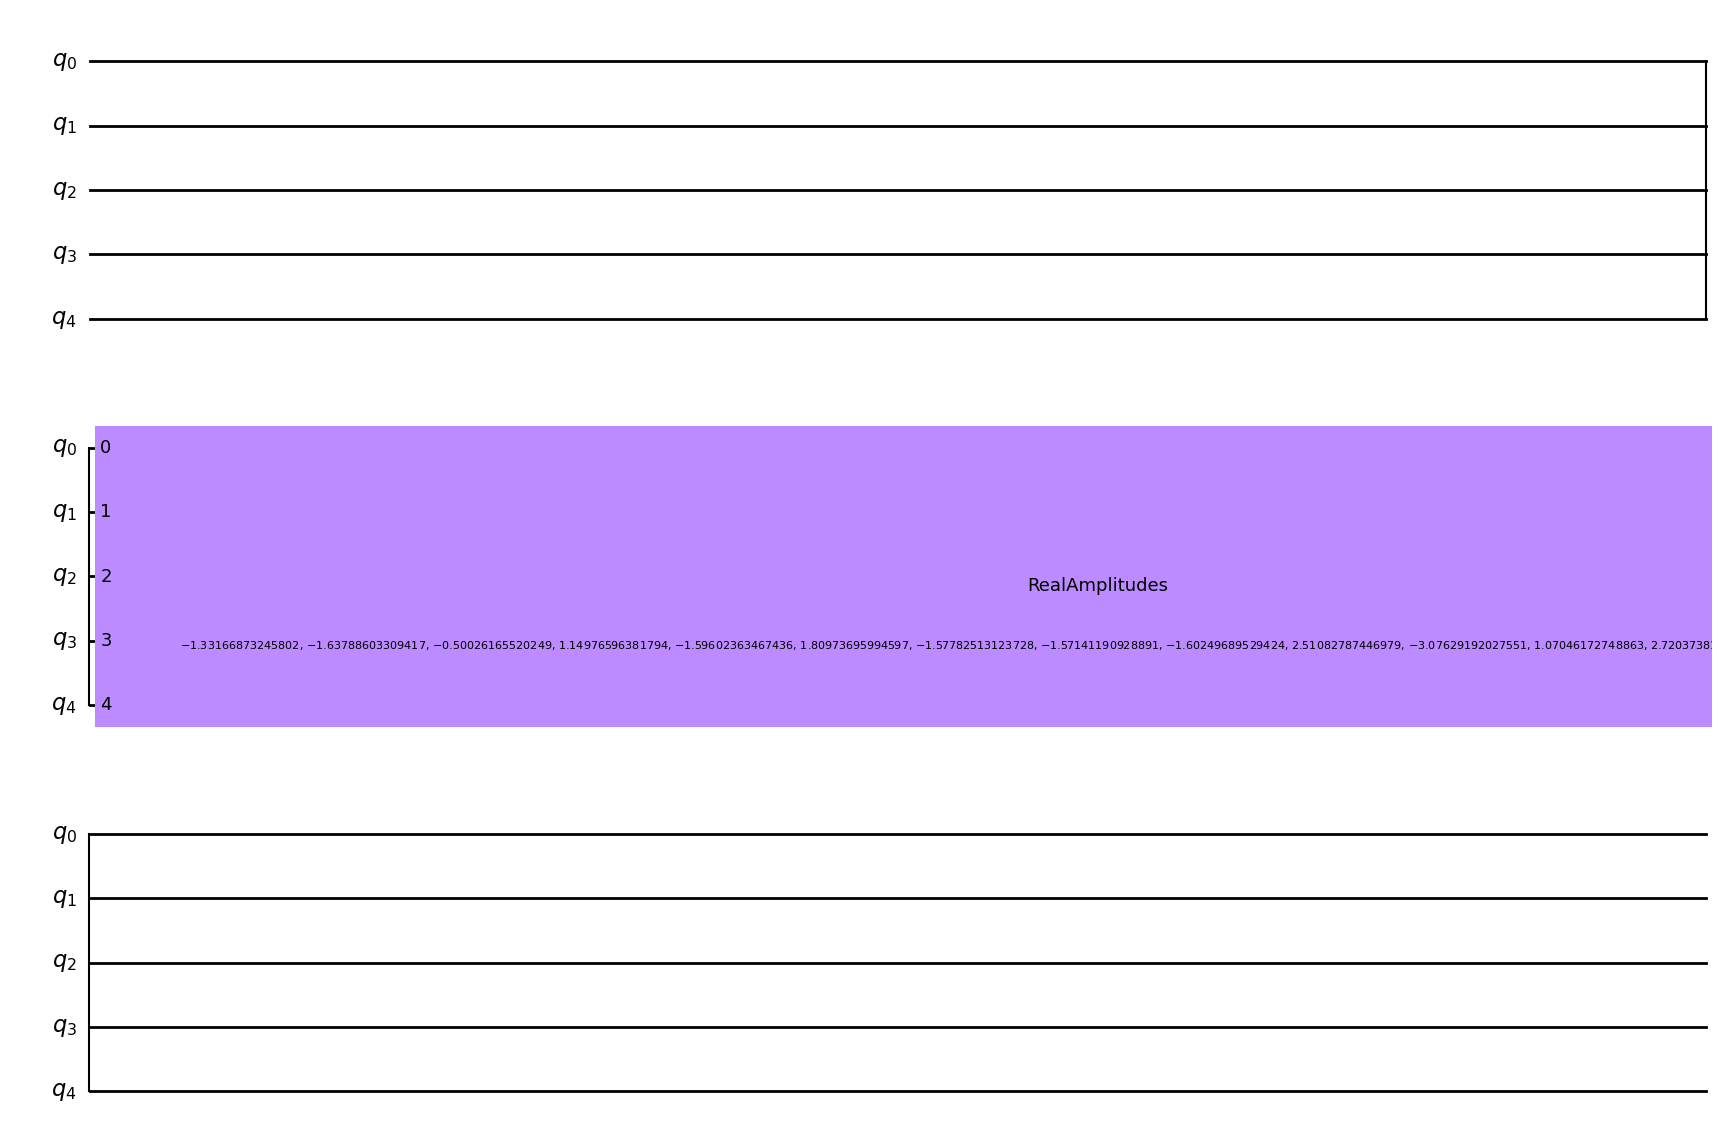

In [12]:
# Se reajusta el circuito después del binding
cir_ansatz=cir_ansatz[-1]

cir_ansatz.draw('mpl')

#### Obtención de los operadores ising, ansatz y total

In [13]:
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import array_to_latex
import numpy as np

oper_ansatz=np.round(Operator(cir_ansatz),2)
print(oper_ansatz.shape)
array_to_latex(oper_ansatz)
oper_ansatz

(32, 32)


array([[-0.  +0.j, -0.02+0.j,  0.08+0.j, ...,  0.  +0.j, -0.  +0.j,
        -0.01+0.j],
       [ 0.  +0.j,  0.35+0.j,  0.  +0.j, ..., -0.01+0.j, -0.57+0.j,
         0.14+0.j],
       [-0.  +0.j, -0.04+0.j,  0.15+0.j, ..., -0.  +0.j,  0.  +0.j,
         0.  +0.j],
       ...,
       [ 0.  +0.j,  0.  +0.j,  0.  +0.j, ..., -0.8 +0.j, -0.01+0.j,
        -0.05+0.j],
       [ 0.  +0.j, -0.  +0.j,  0.  +0.j, ..., -0.03+0.j,  0.1 +0.j,
         0.42+0.j],
       [-0.  +0.j,  0.01+0.j,  0.  +0.j, ...,  0.44+0.j,  0.01+0.j,
         0.03+0.j]])

In [14]:
oper_ising=ising.to_matrix()
print(oper_ising.shape)
array_to_latex(oper_ising)
oper_ising

(32, 32)


array([[ 0.75+0.j,  0.  +0.j,  0.  +0.j, ...,  0.  +0.j,  0.  +0.j,
         0.  +0.j],
       [ 0.  +0.j,  0.75+0.j,  0.  +0.j, ...,  0.  +0.j,  0.  +0.j,
         0.  +0.j],
       [ 0.  +0.j,  0.  +0.j,  0.75+0.j, ...,  0.  +0.j,  0.  +0.j,
         0.  +0.j],
       ...,
       [ 0.  +0.j,  0.  +0.j,  0.  +0.j, ...,  1.75+0.j,  0.  +0.j,
         0.  +0.j],
       [ 0.  +0.j,  0.  +0.j,  0.  +0.j, ...,  0.  +0.j, -3.25+0.j,
         0.  +0.j],
       [ 0.  +0.j,  0.  +0.j,  0.  +0.j, ...,  0.  +0.j,  0.  +0.j,
        -2.25+0.j]])

In [15]:
oper=oper_ansatz.dot(oper_ising)
print(oper.shape)
array_to_latex(oper)
oper

(32, 32)


array([[ 0.    +0.j, -0.015 +0.j,  0.06  +0.j, ...,  0.    +0.j,
         0.    +0.j,  0.0225+0.j],
       [ 0.    +0.j,  0.2625+0.j,  0.    +0.j, ..., -0.0175+0.j,
         1.8525+0.j, -0.315 +0.j],
       [ 0.    +0.j, -0.03  +0.j,  0.1125+0.j, ...,  0.    +0.j,
         0.    +0.j,  0.    +0.j],
       ...,
       [ 0.    +0.j,  0.    +0.j,  0.    +0.j, ..., -1.4   +0.j,
         0.0325+0.j,  0.1125+0.j],
       [ 0.    +0.j,  0.    +0.j,  0.    +0.j, ..., -0.0525+0.j,
        -0.325 +0.j, -0.945 +0.j],
       [ 0.    +0.j,  0.0075+0.j,  0.    +0.j, ...,  0.77  +0.j,
        -0.0325+0.j, -0.0675+0.j]])

Pasamos ahora a la parte fundamental, comprobar e interpretar la evolución del sistema.

### Evolución del sistema

In [22]:
# Fijación del estado inicial del sistema

from qiskit.quantum_info import Statevector

estado_i=Statevector.from_int(0, dims = 32)

estado_i.draw('latex')

<IPython.core.display.Latex object>

In [23]:
#estado que entrega el ansatz al bloque Ising
estado_ansatz=oper_ansatz.dot(estado_i)
Statevector(estado_ansatz).draw('latex')

<IPython.core.display.Latex object>

In [24]:
# estado a la salida Ising
estado_final=oper_ising.dot(estado_ansatz)
Statevector(estado_final).draw('latex')

<IPython.core.display.Latex object>

Vemos que el estado después del operador ising es el mismo. El Ansatz ha preparado pues un autovector, cuyo autovalor es -25/4, y se presupone mínimo.

Este autovalor se puede obtener analíticamente como:

In [25]:
# Autovalor del H_ising
estado_ansatz.dot(estado_final)

(-6.25+0j)

#### La evolución pero por convolución entre ambos operadores

debe de coincidir, se hace como comprobación:


In [26]:
opTotal=oper_ising.dot(oper_ansatz)
opTotal.dot(estado_i)

array([ 0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
        0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
        0.  +0.j,  0.  +0.j, -6.25+0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
        0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
        0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
        0.  +0.j,  0.  +0.j])

In [30]:
estado_final2=opTotal.dot(estado_i)
Statevector(estado_final2).draw('latex')

<IPython.core.display.Latex object>

que coincide con el método por etapas anterior.

### RESUMEN RESULTADOS

In [32]:
print("\nFunción objetivo óptima:",round(result.eigenvalue,3)+offset)
print("Valor esperado H-Ising")
print(np.real(estado_ansatz.dot(oper_ising).dot(estado_ansatz)))
print("Autovalor Ising:")
print(np.real(estado_ansatz.dot(estado_final)))
print("Autoestado Ising:")
Statevector(abs(estado_ansatz)).draw('latex')


Función objetivo óptima: -7.0
Valor esperado H-Ising
-6.25
Autovalor Ising:
-6.25
Autoestado Ising:


<IPython.core.display.Latex object>

Cuyos qbits |q0q1q2q3q4⟩codifican el resultado de las variables qubo binarias al problema planteado:
$$ X_0X_1X_2X_3X_4$$

con

- X0,X4 = 0 ya que tienen cúbits asociados al estado |0>, spin = +1

- X1,X2,X3 = 1 con cúbits asociados al estado |1>, spin =-1

valores que llevados a la expresión de la función de coste:

f=-2*x_0*x_1 + 3*x_0*x_3 - 3*x_1*x_3 + x_1*x_4 - 4*x_2*x_3 - 2*x_2*x_4 + 4*x_3*x_4 = -7.0

acorde al resultado equivalente E_ising + offset: -6.25-0.75


<b>Nota:</b>

Se da la coindicencia de que la función objetivo arroja el mismo resultado sustituyendo $$ X_0X_1X_2X_3X_4 $$ con sus valores binarios de spin {-1,1}, propiedad que, en general, no tiene la función de coste.